# Deep learning (with keras) for House prices regression

In [8]:
%matplotlib inline
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers.core import Dense
import numpy
import seaborn as sns
import matplotlib

### Read the data
-  drop the id column for now as it's now useful  
-  remember the id column for the test data

In [9]:
train_data = pd.read_csv('train.csv').drop('Id',axis=1)
x_test_raw = pd.read_csv('test.csv')
x_test_ids = x_test_raw['Id']
x_test_raw = x_test_raw.drop('Id',axis=1)
y_train = train_data['SalePrice']
x_train_raw = train_data.drop('SalePrice',axis=1)

### Let's check out the features 

In [10]:
x_train_raw.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

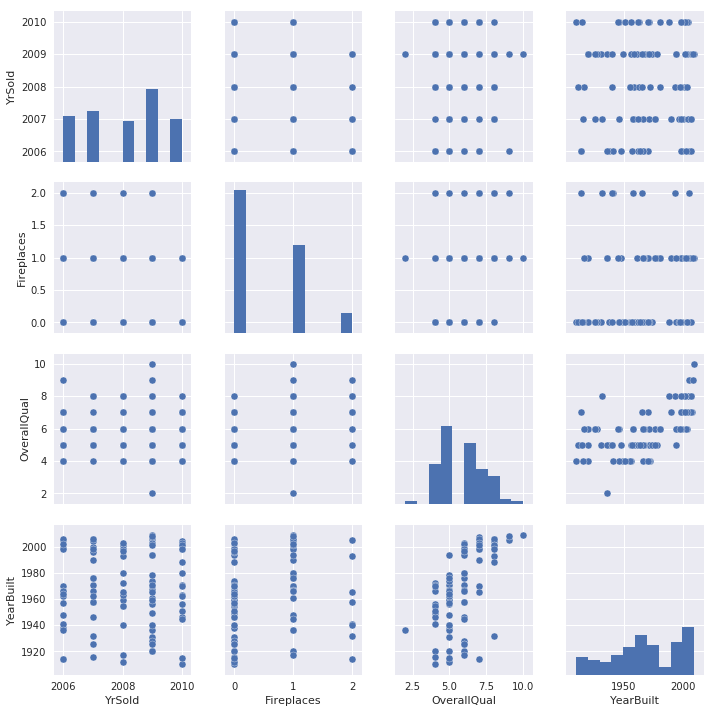

In [12]:
matplotlib.rc('font', family='DejaVu Sans') 
sns.pairplot(x_train_raw[['YrSold','Fireplaces','OverallQual','YearBuilt','HouseStyle']].sample(100), size=2.5);

### Transforming features 
-  categorical -> One hot encoding
- numerical -> scaling

In [ ]:
## popravi ovo, dobit ces los model zbog toga !!
categorical_columns = x_train_raw.columns

for i in x_train_raw.categorical_columns:
    x_train_raw[i] = x_train_raw[i].astype(str)
    x_test_raw[i] = x_test_raw[i].astype(str)
    
dv = DictVectorizer(sparse=False)
dv = dv.fit(x_train_raw.to_dict( orient = 'records' ))

x_train = dv.transform(x_train_raw.to_dict( orient = 'records' ))
x_test = dv.transform(x_test_raw.to_dict( orient = 'records' ))

assert(x_train.shape[1] == x_test.shape[1])

### Building the Keras model
- simple architecture for a regression model
- relu activation function
- mean_squared_logarithmic_error is used as competition metric

In [ ]:
model = Sequential()
model.add(Dense(1024, input_dim= x_train.shape[1], init='normal', activation='relu'))
model.add(Dense(256, init='normal', activation='relu'))
model.add(Dense(64, init='normal', activation='relu'))
model.add(Dense(16, init='normal', activation='relu'))
model.add(Dense(1, init='normal'))

model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')
model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=1)


/grid/0/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, activation="relu", kernel_initializer="normal", input_dim=7648)`
  from ipykernel import kernelapp as app
/grid/0/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
/grid/0/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="normal")`
/grid/0/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="normal")`
/grid/0/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initialize

Epoch 1/100
1460/1460 [==============================] - 230s - loss: 7.0623       

### Write the submission

In [ ]:
y_test = model.predict(x_test)

In [41]:
y_test.ravel()

array([ 121048.3359375,  146860.65625  ,  186593.796875 , ...,
        160211.578125 ,  111716.375    ,  207482.40625  ], dtype=float32)

In [43]:
result = pd.DataFrame({'Id': x_test_ids.tolist(), 'SalePrice': y_test.ravel()})

result.to_csv('submission.csv',index=False)

### Save the model 

In [24]:
from keras.models import load_model

model.save('model_house_prices.h5')  # creates a HDF5 file 'my_model.h5'



In [23]:
print("done")

done


In [26]:
y_test

array([[ 121048.3359375],
       [ 146860.65625  ],
       [ 186593.796875 ],
       ..., 
       [ 160211.578125 ],
       [ 111716.375    ],
       [ 207482.40625  ]], dtype=float32)